In [47]:
# First attempts at getting a range-doppler map of collected hdf5 data

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum

def range_doppler_map(hdf5_file_path, frame):
    
    frame_data = hdf5_file_path[f'Sensors/TI_Radar/Data/Frame_{frame}/frame_data'] # Collect the data of a specific frame, idk just fucking figure it out
    #print(frame_data[0,:,0]) # data is stored as samples x chirps x channels
    range_pad = 0
    doppler_pad = 0

    fftd_frame_data = range_doppler_fft(frame_data, range_pad, doppler_pad)

    plotted_fftd_frame_data = range_doppler_sum(fftd_frame_data)
    plt.figure()
    plt.imshow(np.rot90(plotted_fftd_frame_data, 3), aspect='auto', cmap='jet')
    plt.title('Range-Doppler Map')
    plt.xlabel('Range')
    plt.ylabel('Doppler')
    plt.colorbar(label='Power (dB)')
    plt.show()

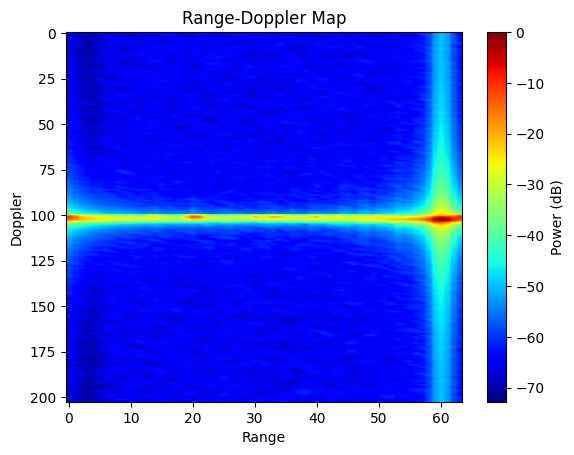

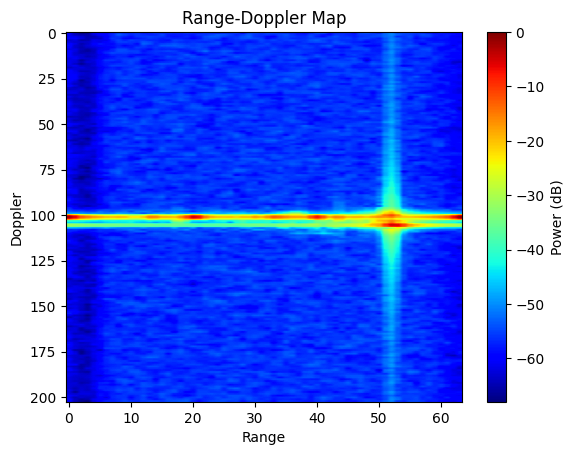

In [46]:
f = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
range_doppler_map(f, '1')
range_doppler_map(f, '125')

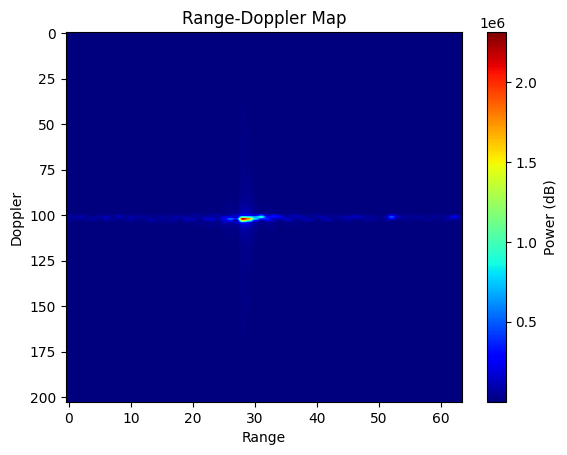

In [44]:
# Trying a homemade range-doppler map - can ignore this
target_frame = 'Sensors/TI_Radar/Data/Frame_0'
frame_data = f[f'{target_frame}/frame_data']#[:,:,0]

window = np.tile(np.hanning(frame_data.shape[1])[np.newaxis, :, np.newaxis], (frame_data.shape[0], 1, frame_data.shape[2]))

after_fast_time_fft = fft(window[:,:,0]*frame_data[:,:,0],frame_data.shape[0],0)
after_slow_time_fft = fftshift(fft(after_fast_time_fft, after_fast_time_fft.shape[1],1))

plt.figure()
plt.imshow(np.rot90(np.abs(after_slow_time_fft)), aspect='auto', cmap='jet')
plt.title('Range-Doppler Map')
plt.xlabel('Range')
plt.ylabel('Doppler')
plt.colorbar(label='Power (dB)')
plt.show()
